In [ ]:
import numpy as np
import os
from CoPhaser import utils
from CoPhaser.trainer import Trainer
from CoPhaser.loss import Loss
from CoPhaser import plotting
from CoPhaser.model import CoPhaser
from CoPhaser import simulation
import sys

sys.path.insert(0, "../set_up")  # add set_up path to search list

import plot_helpers
import constants

from scipy.stats import pearsonr
from scipy.sparse import csr_matrix, hstack, vstack

import matplotlib.pyplot as plt
import seaborn as sns

import anndata
import scanpy as sc

import pandas as pd

In [18]:
#autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


height_ratios_scaling: [3, 2, 2, 3]


<Axes: label='B'>

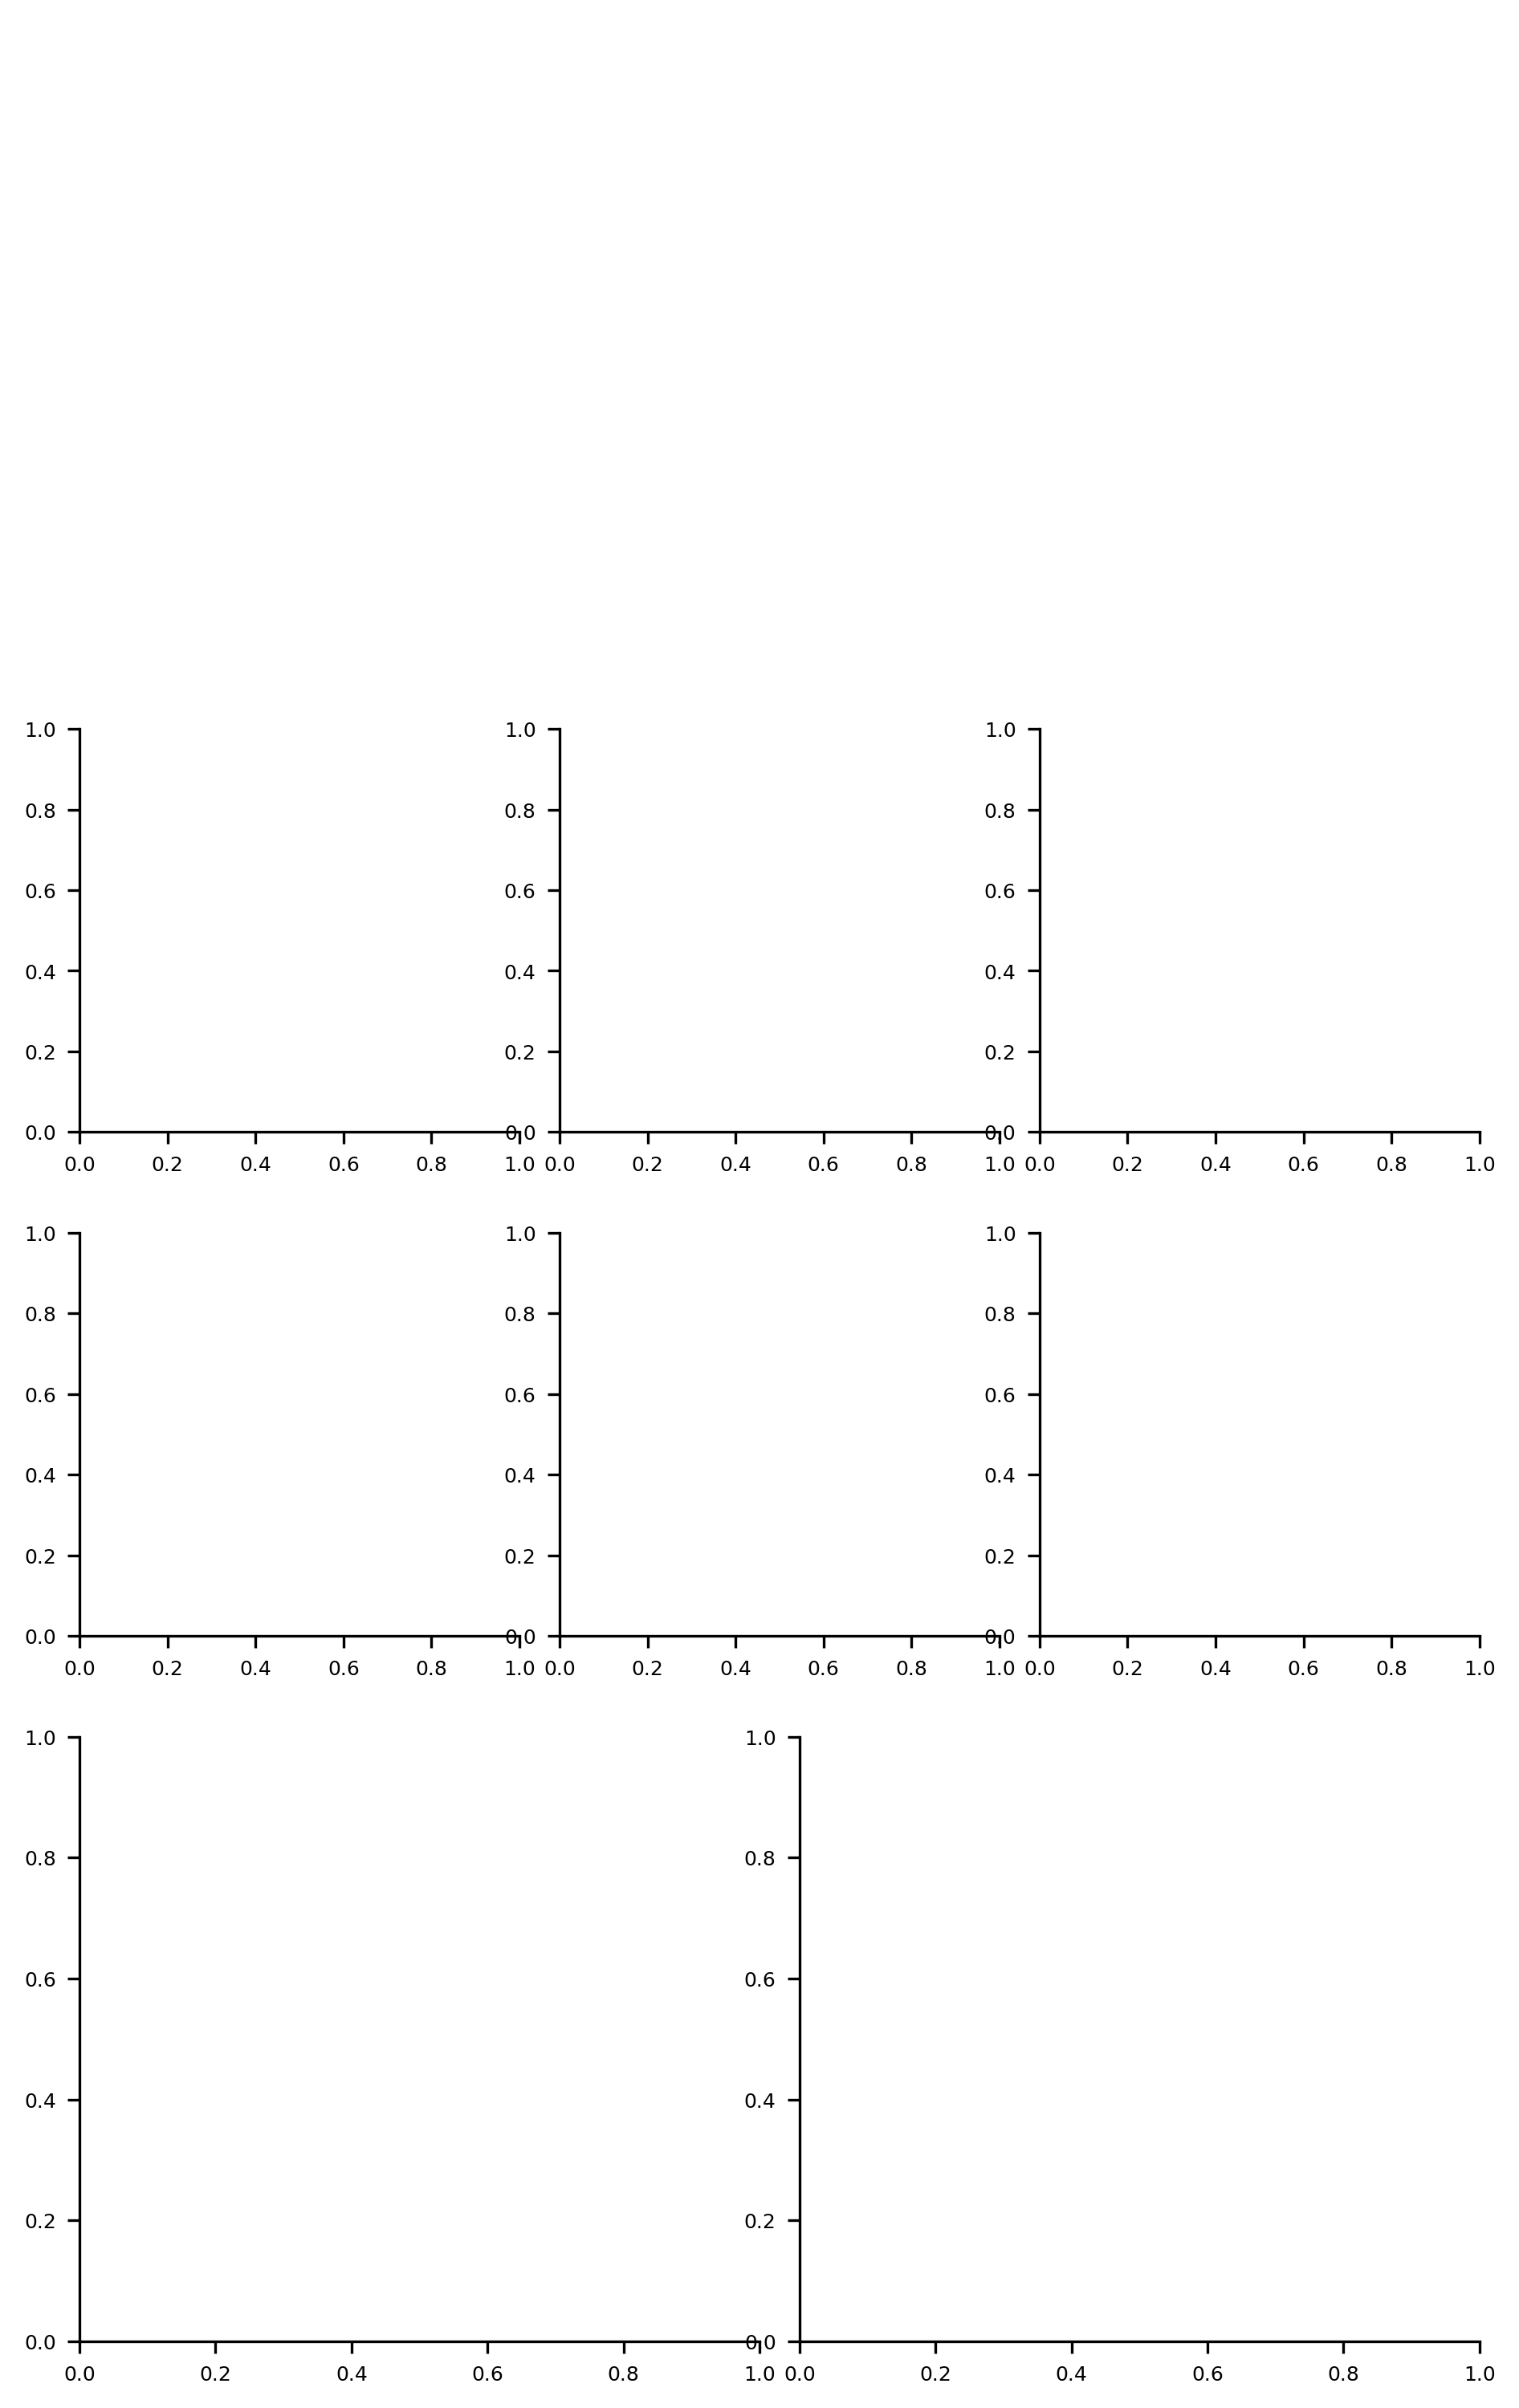

In [19]:
mosaic = [["A", "B"], ["C", "D", "E"], ["F", "G", "H"], ["I", "J"]]
fig, axs = plot_helpers.create_pannels(mosaic=mosaic, h_pad=0, w_pad=100)
plot_helpers.make_blank_panel(axs["A"])
plot_helpers.make_blank_panel(axs["B"])

In [20]:
for ax in [
    axs["C"],
    axs["D"],
    axs["E"],
    axs["F"],
    axs["G"],
    axs["H"],
    axs["I"],
    axs["J"],
]:
    ax.set_box_aspect(1)

In [21]:
# to_save = {
#     "thetas": thetas,
#     "phases": phases,
#     "mu_gt": mu_gt,
#     "mu_pred": mu_pred,
#     "generative_outputs": generative_outputs,
#     "space_outputs": space_outputs,
#     "results_shifts": results_shifts,
# }

In [22]:
import pickle

simulation_data = pickle.load(open("data/res_simulation.pkl", "rb"))
thetas = simulation_data["thetas"]
phases = simulation_data["phases"]
mu_gt = simulation_data["mu_gt"]
mu_pred = simulation_data["mu_pred"]
generative_outputs = simulation_data["generative_outputs"]
space_outputs = simulation_data["space_outputs"]
results_shifts = simulation_data["results_shifts"]
Contexts = simulation_data["pseudotimes"]
lambda_start = simulation_data["lambda_start"]
lambda_end = simulation_data["lambda_end"]
rhythmic_gene_names = simulation_data["rhythmic_gene_names"]

In [23]:
lambda_vals = (1 - Contexts) * lambda_start + Contexts * lambda_end
ax = axs["C"]
cmap = sns.cubehelix_palette(as_cmap=True)
scatter = ax.scatter(
    space_outputs["z"][:, 0],
    space_outputs["z"][:, 1],
    c=Contexts,
    edgecolor=None,
    s=5,
    alpha=0.5,
    cmap=cmap,
)
import matplotlib.cm as cm

norm = plt.Normalize(vmin=Contexts.min(), vmax=Contexts.max())
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, shrink=0.7, label="Context")
cbar.ax.set_yticklabels([])
ax.set_title("z Space")
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlabel("z1")
ax.set_ylabel("z2")

Text(13.33333333333329, 0.5, 'z2')

In [24]:
cells_projected = space_outputs["x_projected"].detach().numpy()
ax = axs["D"]
sns.scatterplot(
    x=cells_projected[:, 0],
    y=cells_projected[:, 1],
    ax=ax,
    alpha=0.2,
    edgecolor=None,
    s=2,
    c=phases,
    cmap="hsv",
)
ax.set_title("f Space")
# remove ticks
ax.set_xticks([])
ax.set_yticks([])

[]

In [25]:
ax = axs["E"]
plotting.modify_axis_labels(ax=ax, axis="both", step=0.5)
sns.histplot(x=phases, y=thetas, bins=50, cmap="rocket_r", ax=ax)
ax.plot(
    [-np.pi, np.pi], [-np.pi, np.pi], color="lightgray", linestyle="--", linewidth=1
)
ax.set_ylabel("Inferred Phase")
ax.set_xlabel("Simulated GT Phase")
ax.set_title("Phase Inference Accuracy")
np.abs(utils.normalize_angles(thetas - phases)).mean()

tensor(0.1616, dtype=torch.float64)

In [26]:
mu_pred.shape

(10000, 97, 100)

In [27]:
ax = axs["F"]
pearson_per_cell_genes = pearsonr(np.log2(mu_pred), np.log2(mu_gt), axis=-1)[0]
sns.histplot(
    pearson_per_cell_genes[:, rhythmic_gene_names != "FEN1"].flatten(),
    bins=100,
    ax=ax,
)
ax.set_xlabel("Pearson Correlation Coefficient")
ax.set_title("Expression Profiles Correlations")

Text(0.5, 1.0, 'Expression Profiles Correlations')

In [28]:
ax = axs["G"]
sns.histplot(
    x=lambda_vals,
    y=generative_outputs["lambda"].flatten().detach().numpy(),
    ax=ax,
    cmap="rocket_r",
    bins=50,
)
ax.set_xlabel("Simulated GT λ")
ax.set_ylabel("Inferred λ")
ax.set_title("Inferred λ Accuracy")

Text(0.5, 1.0, 'Inferred λ Accuracy')

In [29]:
# sns.histplot(x=adata[:, "FEN1"].layers["counts"].toarray().flatten(), discrete=True)
# plt.yscale("log")

In [30]:
# create a 10000,n_genes array with the Contexts
discrete_gt = pd.qcut(
    (
        np.log2(mu_gt[:, ::3, :]).mean(axis=2)
        - np.log2(mu_gt[:, ::3, :]).mean(axis=2).mean(axis=0)
    ).flatten(),
    100,
)
discrete_gt = [x.mid for x in discrete_gt]
i = [i for i in range(0, mu_gt.shape[1], 3)]
ax = axs["H"]
sns.lineplot(
    x=discrete_gt,
    y=(
        np.log2(mu_pred[:, ::3, :]).mean(axis=2)
        - np.log2(mu_pred[:, ::3, :]).mean(axis=2).mean(axis=0)
    ).flatten(),
    ax=ax,
    errorbar="sd",
)
ax.plot([-3.1, 3.1], [-3.1, 3.1], color="black", linestyle="--", linewidth=1)
ax.set_xlim([-3.1, 3.1])
# set ticks at -3,-1.5,0,1.5,3
ax.set_xticks([-3, -1.5, 0, 1.5, 3])
ax.set_ylim([-3.1, 3.1])
ax.set_yticks([-3, -1.5, 0, 1.5, 3])
ax.set_xlabel("Simulated GT Δμ ")
ax.set_ylabel("Inferred Δμ")
ax.set_title("Inferred Δμ Accuracy")

Text(0.5, 1.0, 'Inferred Δμ Accuracy')

In [31]:
def plot_gene_expression_profile(
    ax, gene_name, mu_values, gene_names, type_label="Simulated", max_value=None
):
    cmap = sns.cubehelix_palette(as_cmap=True)
    sns.lineplot(
        np.log2(mu_values[::20, gene_names == gene_name].squeeze().T * 1e4 + 1),
        legend=False,
        dashes=False,
        alpha=1,
        linewidth=2,
        palette=sns.cubehelix_palette(n_colors=500),
        ax=ax,
    )
    # Add colorbar with rainbow colormap

    norm = plt.Normalize(vmin=0, vmax=1)
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, shrink=0.7, label="Context")
    cbar.ax.set_yticklabels([])
    ax.set_ylabel(f"Normalized Counts (log)")
    ax.set_title(f"{type_label} Expression Profile for {gene_name}")
    ax.set_xticks([])
    ax.set_xlabel("Phase")
    if max_value is not None:
        ax.set_ylim(top=max_value)


plot_gene_expression_profile(
    axs["I"],
    "TOP2A",
    mu_gt,
    rhythmic_gene_names,
    type_label="Simulated GT",
)
# axs["I"].set_ylim(-15, -6)
# axs["I"].set_yticks([-14, -12, -10, -8, -6])
plot_gene_expression_profile(
    axs["J"],
    "TOP2A",
    mu_pred,
    rhythmic_gene_names,
    type_label="Predicted",
)
# axs["J"].set_ylim(-15, -6)
# axs["J"].set_yticks([-14, -12, -10, -8, -6])

Figure saved to: /home/maxine/Documents/paychere/cell_cycle_VAE_Fourrier_model/paper/figures/figure_1_python.svg


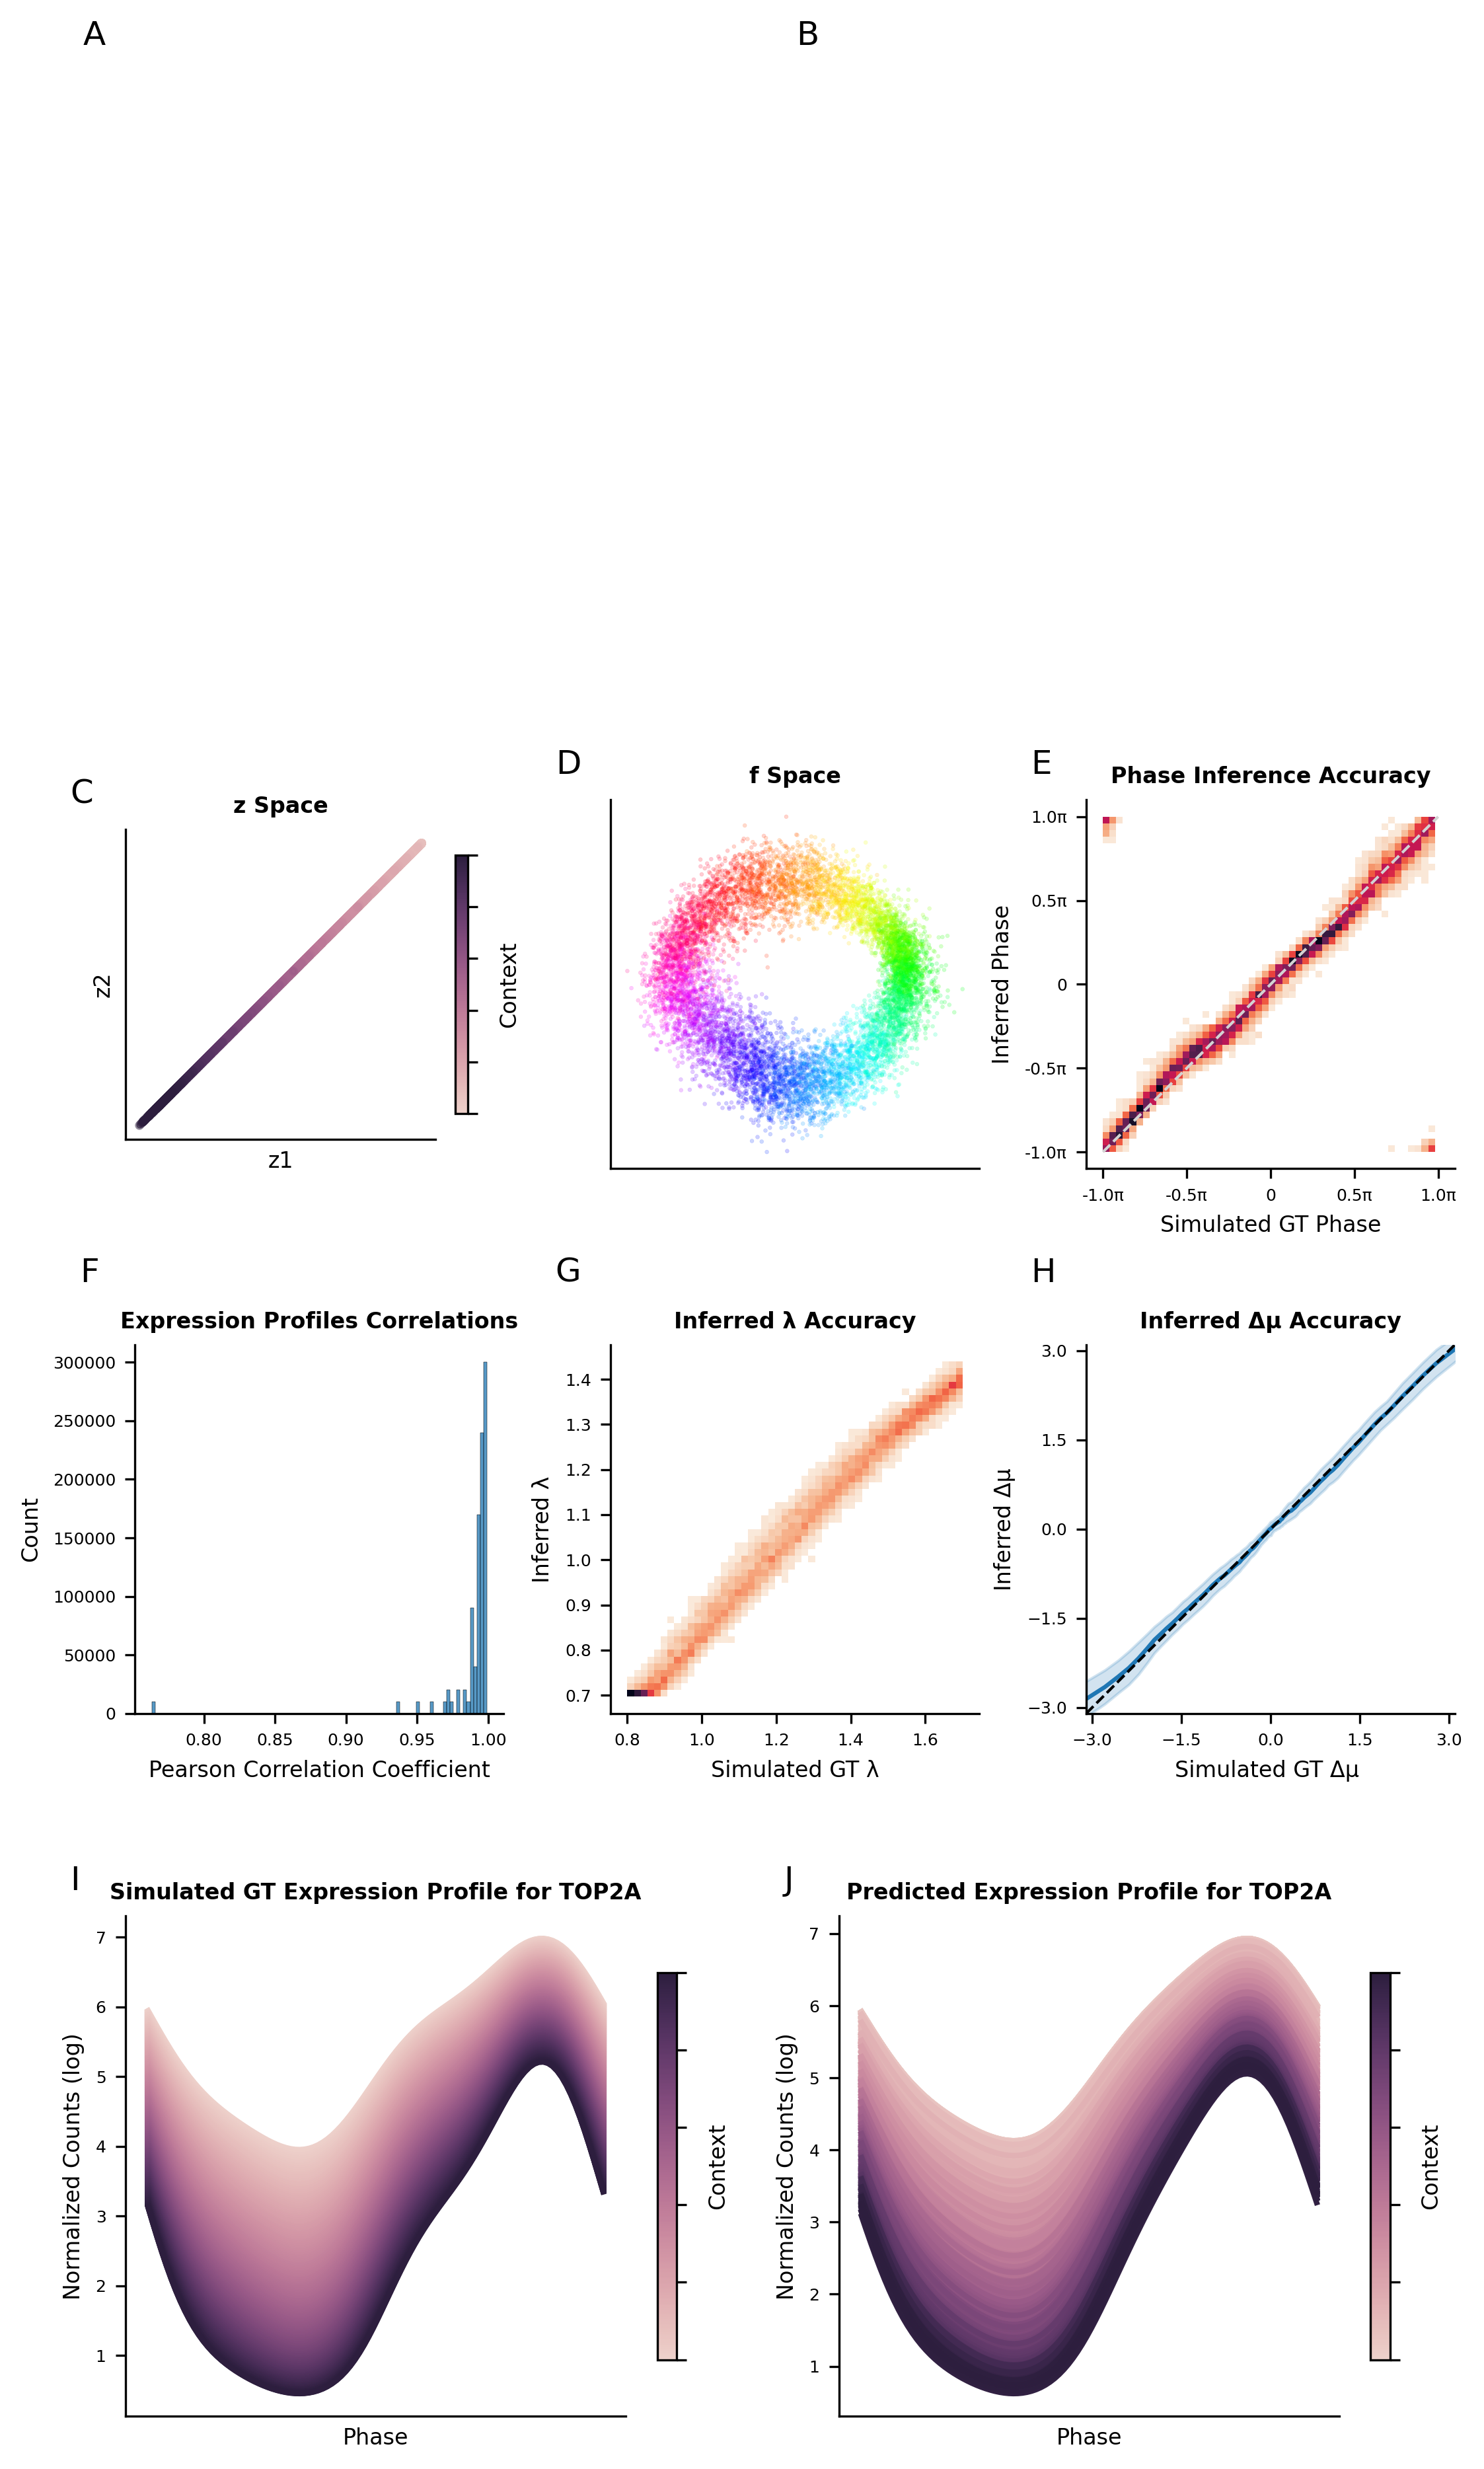

In [32]:
plot_helpers.label_panels_mosaic(
    fig, axs, mosaic, xloc=[0.02, 0, 0, 0], yloc=[1, 1, 1.1, 1]
)
plot_helpers.save_figure(fig, axs, fig_name="figure_1_python")